# Gene Regulatory network Modeling (GRenMlin)


### Libraries

All the required code is implemented in `grn.py` (manipulation of a gene regulatory network, GRN) and `simulator.py` (running the simulations of a constructed network).


In [1]:
import src.simulator as simulator
from src.network_builder import Builder
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

### Constructing the network

Construction of the network is relatively straightforward. First, we need to call a constructor:


In [3]:
grn = Builder()

In the next step, we can add different species. Input species do not degrade, while for all other (ordinary) species degradation rate needs to be specified.


In [4]:
X1 = grn.species("X1")
X2 = grn.species("X2")
Y = grn.species("Y", 0.1)

In the next step we can add a gene, which will be defined by a set of regulators and a set of products.

The first gene will describe the function `not X1 and X2`


In [5]:
# !! if you run this cell multiple times, multiple gene instances will be added to the network
grn.gene(
    regulators=[X1.represses(Kd=5, n=2), X2.activates(Kd=5, n=3)],
    products=[Y],
    alpha=10,
)

Similarly, we can add another gene. The second gene will describe the function `X1 and not X2`. Since both genes will produce the same output (`Y`) the network will implement `Y = (not X1 and X2) OR (X1 and not X2) = X1 XOR X2`.


In [6]:
grn.gene(
    regulators=[X1.activates(Kd=5, n=2), X2.represses(Kd=5, n=3)],
    products=[Y],
    alpha=10,
)

We can check which genes are in the network:


In [7]:
grn.grn.genes

[{'alpha': 10,
  'regulators': [{'name': 'X1', 'type': -1, 'Kd': 5, 'n': 2},
   {'name': 'X2', 'type': 1, 'Kd': 5, 'n': 3}],
  'products': [{'name': 'Y'}],
  'logic_type': 'and'},
 {'alpha': 10,
  'regulators': [{'name': 'X1', 'type': 1, 'Kd': 5, 'n': 2},
   {'name': 'X2', 'type': -1, 'Kd': 5, 'n': 3}],
  'products': [{'name': 'Y'}],
  'logic_type': 'and'}]

or plot the network (**red** arrows represent inhibition, **blue** arrows represent activation, and **orange** arrows represent both):


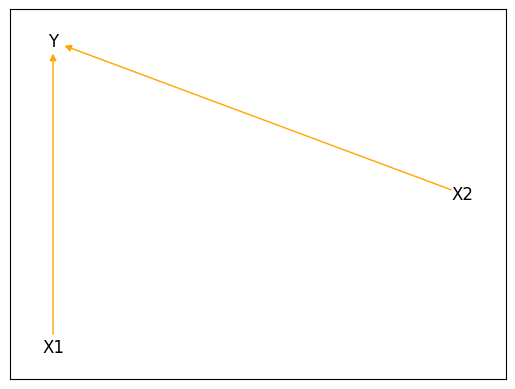

In [8]:
grn = grn.grn
grn.plot_network()

Finally, we can run some simulations to test the dynamics of the established network:


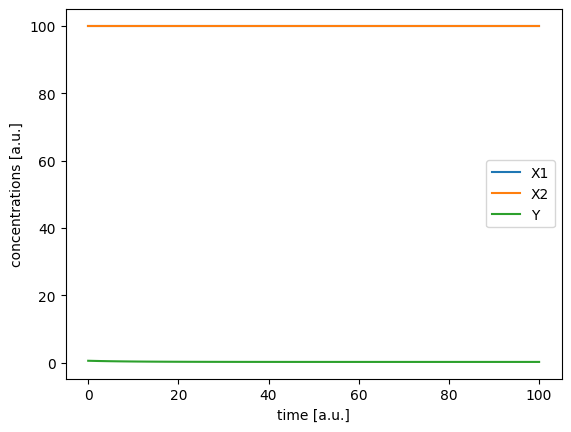

In [9]:
# specify inputs

IN = np.zeros(len(grn.input_species_names))
IN[0] = 100
IN[1] = 100

T, Y = simulator.simulate_single(grn, IN)

The simulations can also be performed for a sequence of inputs. In this case, we also need to specify for how long each input combination will be held (`t_single`).


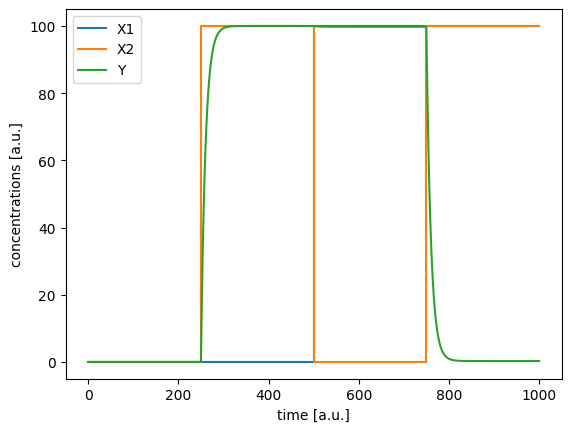

In [10]:
T, Y = simulator.simulate_sequence(
    grn, [(0, 0), (0, 100), (100, 0), (100, 100)], t_single=250
)

We can observe the following dynamics:

- For the first 250 time units, both inputs (`X1` and `X2`) are absent (logical 0) and so is the output (`Y`).
- The next 250 time units (from `t=250 a.u.` to `t=500 a.u.`) the first input (`X1`) is absent (logical 0) and the second output (`X2`) is present (logical 1). This activates the output (`Y`).
- The next 250 time units (from `t=500 a.u.` to `t=750 a.u.`) the first input (`X1`) is present (logical 1) and the second output (`X2`) is absent (logical 0). This activates the output (`Y`).
- The last 250 time units (from `t=750 a.u.` to `t=1000 a.u.`) both inputs (`X1` and `X2`) are present (logical 1). This inactivates the output (`Y`).


{'steady_states': [{'A': 2, 'B': 1, 'C': 1}, {'A': 0, 'B': 0, 'C': 0}], 'cyclic_attractors': [({'A': 0, 'B': 1, 'C': 1}, {'A': 1, 'B': 0, 'C': 1}, {'A': 2, 'B': 1, 'C': 0})]}


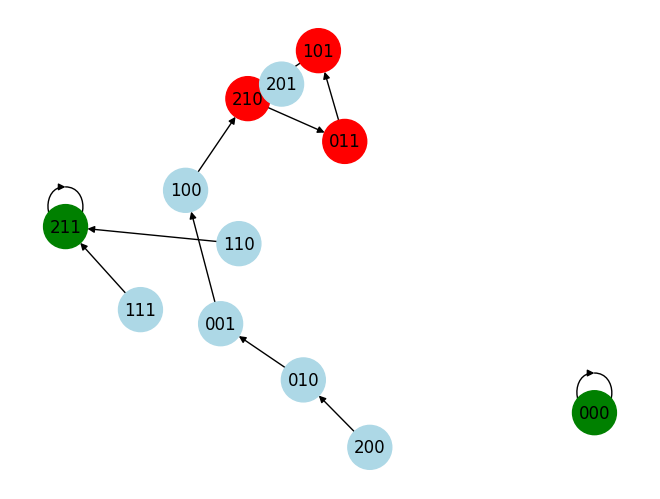

In [19]:
from src import simulator
from src.grn import GRN
from src.qual_sbml import QualModel


def main():
    qual_model = QualModel("qualSBML/regulator.xml")
    attr = qual_model.find_attractors()
    print(attr)
    qual_model.plot_network()


if __name__ == "__main__":
    main()